<a href="https://colab.research.google.com/github/mmsamiei/MS-Thesis-Phase3/blob/master/Models/Montazeri/Montazeri_L-2-2_H-256_Plus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#In the name of God

In [2]:
import IPython
from google.colab import output

display(IPython.display.Javascript('''
  function ClickConnect(){
    console.log("Working"); 
    document.querySelector("colab-connect-button").click() 
  }
  var connect_timer = setInterval(ClickConnect,60000)
'''))

print("Done.")

<IPython.core.display.Javascript object>

Done.


In [3]:
!nvidia-smi

Mon Jul 20 09:52:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
!git clone https://github.com/mmsamiei/transformers-zirab
%cd transformers-zirab/
%pip install .

Cloning into 'transformers-zirab'...
remote: Enumerating objects: 34926, done.
remote: Total 34926 (delta 0), reused 0 (delta 0), pack-reused 34926
Receiving objects: 100% (34926/34926), 25.42 MiB | 1.70 MiB/s, done.
Resolving deltas: 100% (24157/24157), done.
/content/transformers-zirab
Processing /content/transformers-zirab
     |████████████████████████████████| 3.0MB 7.3MB/s 
     |████████████████████████████████| 1.1MB 37.7MB/s 
     |████████████████████████████████| 890kB 37.6MB/s 
  Created wheel for transformers: filename=transformers-3.0.2-cp36-none-any.whl size=789366 sha256=6eced470a67e71f803b33ef1d140252e51b026152d2eaf113dcfadbb5010ec53
  Stored in directory: /root/.cache/pip/wheels/df/8c/41/d59504f36bccc68fab7ab4a6ba91e9810d1ae946282e7d0c7e
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=b99f8e8ee0f562160b8d50d633b34ceb1526395752bd0cf94218b8fa6429eed1
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a

In [6]:
from torch.utils.data import Dataset, DataLoader
import os
import torch
import json
from torch.utils.data.sampler import SubsetRandomSampler
from transformers import AutoTokenizer
import random
import pandas as pd
import logging
import os

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from transformers import AutoModel

# Dataset

In [7]:
train_file = '/content/drive/My Drive/Thesis/phase-3/hkr_train.csv'
valid_file =  '/content/drive/My Drive/Thesis/phase-3/hkr_valid.csv'
test_seen_file = '/content/drive/My Drive/Thesis/phase-3/hkr_test_seen.csv'
test_unseen_file = '/content/drive/My Drive/Thesis/phase-3/hkr_test_unseen.csv'
last_sentence_file = '/content/drive/My Drive/Thesis/phase-3/last_sentence.csv'
squad_file = '/content/drive/My Drive/Thesis/phase-3/squad.csv'

In [8]:
enc_tokenizer = AutoTokenizer.from_pretrained('google/bert_uncased_L-2_H-256_A-4')
dec_tokenizer = AutoTokenizer.from_pretrained('google/bert_uncased_L-2_H-256_A-4')

In [9]:
class MyDataset(Dataset):
    """My dataset."""

    def __init__(self, csv_file, frac=1, split_rate=1, max_len=512, sort=True, bound=False):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
        """
        self.dialogues = pd.read_csv(csv_file)
        #self.dialogues.dropna(inplace=True)
        
        self.dialogues.fillna("", inplace=True)
        self.dialogues = self.dialogues[self.dialogues.index % split_rate == 0]

        #self.dialogues = self.dialogues.sample(frac=frac)
        
        if bound:
          len_prt = int(len(self.dialogues) / 5)
          self.dialogues = self.dialogues[ : len_prt]

        s = self.dialogues['response'].apply(dec_tokenizer.encode).apply(len).sort_values().index
        self.dialogues = self.dialogues.reindex(s)

        

        #self.dialogues.dropna(inplace=True)

        self.max_len = max_len


    def __len__(self):
        return len(self.dialogues)

    @staticmethod
    def truncuate_join_pair_sentence(sentence1, sentence2, max_len=510):

        """
        truncuate sentence one from head and sentence two from tail
        Args:
            sentence1 (string): first sentence
            sentence2 (string): seconde sentence
        """
        temp1 = enc_tokenizer.encode(sentence1,add_special_tokens=False)
        temp2 = enc_tokenizer.encode(sentence2,add_special_tokens=False)
        ### two above line may cause warning but no problem because we've handle them below
        logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)
        seq_1 = temp1
        seq_2 = temp2
        num_tokens_to_remove = len(temp1) + len(temp2) + 3 - max_len
        if num_tokens_to_remove > 0 :
            seq_1, seq_2, _ = enc_tokenizer.truncate_sequences(temp1[::-1],temp2, num_tokens_to_remove=num_tokens_to_remove,
                                                               truncation_strategy='longest_first')
            seq_1.reverse()
        result_list = [enc_tokenizer.cls_token_id]+seq_1+[enc_tokenizer.sep_token_id]+seq_2+[enc_tokenizer.sep_token_id]
        token_type_ids = [0] * (len(seq_1) + 2) + [1] * (len(seq_2) + 1)
        return result_list, token_type_ids


    def __getitem__(self, idx):
      
        
        history = self.dialogues.iloc[idx].history
        knowledge = self.dialogues.iloc[idx].knowledge
        response = self.dialogues.iloc[idx].response


        input_pair, input_pair_segments = MyDataset.truncuate_join_pair_sentence(history, knowledge, self.max_len)
                

        input_pair = torch.LongTensor(input_pair)

        input_pair_segments = torch.LongTensor(input_pair_segments)

        response_tensor = torch.LongTensor(dec_tokenizer.encode(response, truncation=True, max_length=128))

        sample = {'input_pair': input_pair,
                  'input_pair_segments': input_pair_segments,
                  'response': response_tensor}

        return sample


In [10]:
train_dataset = MyDataset(train_file, max_len=128, bound=False)
valid_dataset = MyDataset(valid_file, max_len=128)
test_seen_dataset = MyDataset(test_seen_file, max_len=128)
test_unseen_dataset = MyDataset(test_unseen_file, max_len=128)
print(len(train_dataset))
print(len(valid_dataset))
print(len(test_seen_dataset))
print(len(test_unseen_dataset))

41489
4458
2224
2075


In [11]:
print(enc_tokenizer.decode(train_dataset[500]['input_pair']))
print(dec_tokenizer.decode(train_dataset[500]['response']))

[CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in contrast to road transport, where vehicles run on a prepared flat surface, rail vehicles ( rolling stock ) are directionally guided by the tracks on which they run. [SEP]
[CLS] rail vehicles use tracks and not roads [SEP]


In [12]:
from tqdm.auto import tqdm

def my_collate_fn(batch):

  len_batch = len(batch)

  
  max_len_input_pair = max([len(data['input_pair']) for data in batch])

  max_len_response = max([len(data['response']) for data in batch])
  
  padding_ind = 0 ## for bert is 0 DON'T THINK BAD IT IS NOT REFACTORING !!!!!!
  result_input_pair = torch.zeros(len_batch, max_len_input_pair)
  result_input_pair_segments = torch.zeros(len_batch, max_len_input_pair)
  result_response = torch.zeros(len_batch, max_len_response)

  for i, data in enumerate(batch):
    p1 = len(data['input_pair'])
    result_input_pair[i, :p1] = data['input_pair']

    p3 = len(data['input_pair_segments'])
    result_input_pair_segments[i, :p3] = data['input_pair_segments']

    p4 = len(data['response'])
    result_response[i, :p4] = data['response']

  return result_input_pair.long(), result_input_pair_segments.long(), result_response.long()

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64,
                                             shuffle=False, collate_fn=my_collate_fn,
                                           num_workers=1)

#valid_sampler = torch.utils.data.SequentialSampler(valid_dataset)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64,
                                             shuffle=False, collate_fn=my_collate_fn, num_workers=1)

i = 0 
for batch_idx, batch  in tqdm(enumerate(train_loader)):
  pair_batch, segment_batch, response_batch = batch
  print(pair_batch.shape)
  print(segment_batch.shape)
  print(response_batch.shape)
  print("****")
  i += 1 
  if(i==2):
    break

print(len(train_loader))
print(len(valid_loader))

torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 6])
****
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 7])
****
649
70


# Model

In [13]:
from transformers import EncoderDecoderModel, BertTokenizer

class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()

    self.seq2seq = EncoderDecoderModel.from_encoder_decoder_pretrained(
        'google/bert_uncased_L-2_H-256_A-4', 'google/bert_uncased_L-2_H-256_A-4')
    
    # for p in self.seq2seq.encoder.embeddings.parameters():
    #    p.requires_grad = False
    
    # for p in self.seq2seq.decoder.bert.embeddings.parameters():
    #    p.requires_grad = False

  def forward(self, encoder_input, segments_tensors, decoder_input):
    '''
    encoder_input = [batch_size, enc_len]
    segments_tensors = [batch_size, enc_len]
    decoder_input = [batch_size, dec_len]
    '''
    kwargs = {'token_type_ids':segments_tensors}
    outputs = self.seq2seq(input_ids=encoder_input, decoder_input_ids=decoder_input, **kwargs)[0]
    return outputs
  
  def generate(self, encoder_input, segments_tensors, **kwargs):
    ### encoder_input = [len] in int format
    ### segment_tensors = [len]
    encoder_input = encoder_input.unsqueeze(0)
    segments_tensors = segments_tensors.unsqueeze(0)
    
    kwargs ['token_type_ids'] = segments_tensors
    generated = model.seq2seq.generate(input_ids=encoder_input,
        decoder_start_token_id=101,bos_token_id=101,
        eos_token_id=102, **kwargs)

    #### generated = [1, len]
    return generated
    

In [14]:
dev = torch.device('cuda')
model = Model().to(dev)

# x = torch.LongTensor(200, 40).random_(1,1000).to(dev)
# print(model(x).shape)


def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f93246ab208>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


Some weights of the model checkpoint at google/bert_uncased_L-2_H-256_A-4 were not used when initializing BertLMHeadModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertLMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertLMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertLMHeadModel were not initialized from the model checkpoint at google/bert_uncased_L-2_H-256_A-4 and are newly initialized: ['bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.sel

19806266


#Optimizer



In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

In [16]:
from transformers import get_cosine_schedule_with_warmup, get_constant_schedule
scheduler = get_constant_schedule(optimizer)

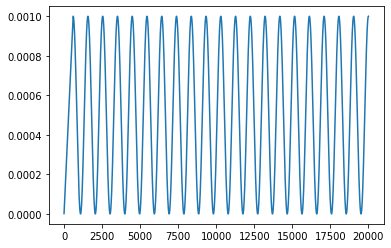

In [ ]:
lrs = []
for i in tqdm(range(20000)):
  optimizer.step()
  scheduler.step()
  lrs.append(scheduler.get_last_lr()[0])
import matplotlib.pyplot as plt
plt.plot(lrs)

# Training

In [ ]:
df = pd.read_csv(train_file)
freqs = [1] * dec_tokenizer.vocab_size
for response in tqdm(df['response']):
  tknzd = dec_tokenizer.encode(response)
  for tkn in tknzd:
    freqs[tkn] += 1

In [17]:
def get_weights(_lambda = 0):
  weights = torch.ones(dec_tokenizer.vocab_size)
  # for idx, freq in enumerate(freqs):
  #   weight = 1 / (freq**_lambda)
  #   weights[idx] = weight
  return weights

In [18]:
import torch.nn

weight = get_weights().to(dev)

def mahdi_loss(model_output, true_trg, **kwargs):
  '''
  model_output: [batch, len, hidden]
  true_trg: [batch, len]
  '''
  model_output = model_output[:,:-1,:]
  true_trg = true_trg[:,1:]

  # cold
  #T = 1
  #model_output = model_output / T

  if 'easy_training' in kwargs:
    print("Easy training")
    limit_last_tokens = kwargs['easy_training']
    model_output = model_output[:,-limit_last_tokens:,:]
    true_trg = true_trg[:,-limit_last_tokens:]

  batch_len = model_output.shape[0]
  snt_len = model_output.shape[1]
  hidden_size = model_output.shape[2]

  model_output = model_output.reshape(-1, hidden_size)
  true_trg = true_trg.reshape(-1)

  loss_mod = nn.CrossEntropyLoss(weight=weight, ignore_index=0)## PAD = 0
  loss = loss_mod(model_output, true_trg)



  #z = torch.LongTensor(model_output[true_trg!=1045].shape[0]).fill_(1045).to(dev)
  #neg_loss = -0.5*F.nll_loss(nn.functional.log_softmax(model_output[true_trg!=1045]), z, reduction='mean')

  return loss 

In [19]:
from tqdm.auto import tqdm

def train_step(batch_idx, batch):
  pair_batch, segment_batch, response_batch = batch
  pair_batch = pair_batch.to(dev)
  segment_batch = segment_batch.to(dev)
  response_batch = response_batch.to(dev)
  model_output = model(pair_batch, segment_batch, response_batch)
  #kwargs = {'easy_training':4}
  loss = mahdi_loss(model_output, response_batch)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  scheduler.step()
  del pair_batch
  del segment_batch
  del response_batch
  return loss.item()

def valid_step(batch_idx, batch):
  with torch.no_grad():
    pair_batch, segment_batch, response_batch = batch
    pair_batch = pair_batch.to(dev)
    segment_batch = segment_batch.to(dev)
    response_batch = response_batch.to(dev)
    model_output = model(pair_batch, segment_batch, response_batch)
    loss = mahdi_loss(model_output, response_batch)
    del pair_batch
    del segment_batch
    del response_batch
    return loss.item()

def valid_loop(valid_loader):
  total_loss = 0
  model.eval()
  for batch_idx, batch in tqdm(enumerate(valid_loader),  total=len(valid_loader), leave=False):
    total_loss += valid_step(batch_idx, batch)
  
  print("temperature is 1:")
  kwargs = {'num_beams':8,'num_return_sequences':8,'temperature':1,
            'no_repeat_ngram_size':3}
  #kwargs = {}
  valid_inference(**kwargs)

  print("most greedy sentence:")
  kwargs = {
          'num_return_sequences':1,'temperature':1, 'max_length':50, 'early_stopping':True,
          'no_repeat_ngram_size':3,
          'top-k':1
          }
  #kwargs = {}
  valid_inference(**kwargs)

  # print("temperature is 2:")
  # kwargs = {'num_beams':16,'num_return_sequences':16,'temperature':2}
  # valid_inference(**kwargs)


  model.train()
  return total_loss / len(valid_loader)

def valid_inference(idx=500, **kwargs):
  hk_pair =  train_dataset[idx]['input_pair'].to(dev)
  hk_segment = train_dataset[idx]['input_pair_segments'].to(dev)
  response = train_dataset[idx]['response'].to(dev)
  generateds = model.generate(hk_pair, hk_segment, **kwargs)
  print("pair is: ",enc_tokenizer.decode(hk_pair))
  print("response is: ",dec_tokenizer.decode(response))
  for generated in generateds:
    print("model says: ",dec_tokenizer.decode(generated))

In [20]:
new_learning = True
if new_learning:
  # optimizer = NoamOpt(128, 1, 2000,
  #           torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
  model_dir = "/content/drive/My Drive/Thesis/phase-3/Models/Montazeri/L-2-2_H-256_Plus"
  step = 0
  log_list = []

In [ ]:
## if continue learning:
#!wget -q https://github.com/mmsamiei/MS-Thesis-Phase2/raw/master/Models/hashemi_16000steps.model
model_dir = "/content/drive/My Drive/Thesis/phase-3/Models/Montazeri/L-6-6_H-256_Plus"
checkpoint = torch.load(model_dir+'/montazeri_60009steps.model')
step = checkpoint['log_list'][-1]['step']
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
optimizer._step = step
log_list = checkpoint['log_list']
best_valid = checkpoint['best_valid']
new_learning = False
print(step)

5999


In [21]:
from tqdm.auto import tqdm

MAX_STEP = 20000
STEP_SAVE = 1000
STEP_CHECK = 500
step_num = step + 1
best_valid = 99999999
log_list = log_list ### Check if new learning or not

print(step_num)

while step_num <= MAX_STEP:
  model.train()
  for batch_idx, batch in tqdm(enumerate(iter(train_loader)), total=len(train_loader), leave=False):
    step_loss = train_step(batch_idx, batch)
    log = {'step':step_num, 'train_loss':step_loss}

    if(step_num % STEP_CHECK == 0):
      valid_error = valid_loop(valid_loader)
      train_losses = [step['train_loss'] for step in log_list[-100:]]
      avg_train_loss = sum(train_losses) / len(train_losses)
      print("train Loss rate: {} at step {}".format(avg_train_loss, step_num))  
      print("valid Loss rate: {} at step {}".format(valid_error, step_num))  
      log['valid_loss'] = valid_error

      if valid_error < best_valid:
        best_valid = valid_error
        torch.save({
            'model_state_dict': model.state_dict(),
            'log_list': log_list,
            'optimizer_state_dict': optimizer.state_dict(),
            'best_valid': best_valid
            }, model_dir+'/montazeri_best_valid.model'.format(step_num))

    log_list.append(log)

    if(step_num % STEP_SAVE == 0):
      torch.save({
            'model_state_dict': model.state_dict(),
            'log_list': log_list,
            'optimizer_state_dict': optimizer.state_dict(),
            'best_valid': best_valid
            }, model_dir+'/montazeri_{}steps.model'.format(step_num))
    step_num += 1

1


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in contrast to road transport, where vehicles run on a prepared flat surface, rail vehicles ( rolling stock ) are directionally guided by the tracks on which they run. [SEP]
response is:  [CLS] rail vehicles use tracks and not roads [SEP]
model says:  [CLS] i'm not sure it's sure that's a lot of the way of the
model says:  [CLS] i'm not sure it's sure that's a lot of the world. i
model says:  [CLS] i'm sure it's not sure that's a lot of the way of the
model says:  [CLS] i'm not sure it's sure that's a lot of the way. i
model says:  [CLS] i'm not sure it's sure that's a lot of the way of a
model says:  [CLS] i'm sure it's not sure that's a lot of the way of a
model says:  [CLS] i'm not sure it's sure that's a lot of the way to be
model says:  [CLS] i'm sure it's not sure that's a lot of the way to be
most greedy sentence:
pair is:  [CLS] rail transport [SE

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in contrast to road transport, where vehicles run on a prepared flat surface, rail vehicles ( rolling stock ) are directionally guided by the tracks on which they run. [SEP]
response is:  [CLS] rail vehicles use tracks and not roads [SEP]
model says:  [CLS] i'm not sure, but it's a lot of cars. i have a lot
model says:  [CLS] i'm not sure. it's a lot of cars. i've never been
model says:  [CLS] i'm not sure. it's a lot of cars. i've tried to
model says:  [CLS] i'm not sure, but it's a lot of cars. i've never
model says:  [CLS] i'm not sure, but it's a lot of cars. i've been
model says:  [CLS] i'm not sure, but it's a lot of cars, but i've
model says:  [CLS] i'm not sure. it's a lot of cars. i've never tried
model says:  [CLS] i'm not sure, but it's a lot of cars. it is a lot
most greedy sentence:
pair is:  [CLS] rail transport [SEP] i believe rail transpor

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in contrast to road transport, where vehicles run on a prepared flat surface, rail vehicles ( rolling stock ) are directionally guided by the tracks on which they run. [SEP]
response is:  [CLS] rail vehicles use tracks and not roads [SEP]
model says:  [CLS] i'm not sure, but it's a lot of traffic. [SEP]
model says:  [CLS] i'm not sure. it's a lot of vehicles. [SEP] [SEP]
model says:  [CLS] i'm not sure. it's a lot of cars. [SEP] [SEP]
model says:  [CLS] i'm not sure, but it's a lot of transportation. [SEP]
model says:  [CLS] i'm not sure. it's a lot of transportation. [SEP] [SEP]
model says:  [CLS] i'm not sure but it's a lot of cars. [SEP] [SEP]
model says:  [CLS] i'm not sure but it's a lot of vehicles. [SEP] [SEP]
model says:  [CLS] i'm not sure. it's a lot of traffic traffic. [SEP]
most greedy sentence:
pair is:  [CLS] rail transport [SEP] i believe r

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:
pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in contrast to road transport, where vehicles run on a prepared flat surface, rail vehicles ( rolling stock ) are directionally guided by the tracks on which they run. [SEP]
response is:  [CLS] rail vehicles use tracks and not roads [SEP]
model says:  [CLS] i have a lot of traffic traffic. [SEP] [SEP] [SEP]
model says:  [CLS] i have a lot of transportation. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i have a lot of traffic. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i have a lot of roads. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i have a lot of traffic traffic traffic. [SEP] [SEP]
model says:  [CLS] i have a lot of vehicles. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i have a lot of traffic traffic [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yes, it is also used by rail rail. [SEP]
most greedy sentence:
pair is:  [CLS] rail transport [S

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in contrast to road transport, where vehicles run on a prepared flat surface, rail vehicles ( rolling stock ) are directionally guided by the tracks on which they run. [SEP]
response is:  [CLS] rail vehicles use tracks and not roads [SEP]
model says:  [CLS] i'm not sure, but i don't know that it's a lot of
model says:  [CLS] i'm not sure, but i don't know that it's hard to be
model says:  [CLS] i'm not sure, but i don't know that it's hard to get
model says:  [CLS] i'm not sure, but i don't know that it's very easy to
model says:  [CLS] i'm not sure, but i don't know that it's easy to get
model says:  [CLS] i'm not sure, but i don't know that it's hard to make
model says:  [CLS] i'm not sure, but i don't know that it's easy to be
model says:  [CLS] i'm not sure, but i don't know that it's just a lot
most greedy sentence:
pair is:  [CLS] rail transport [SE

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in contrast to road transport, where vehicles run on a prepared flat surface, rail vehicles ( rolling stock ) are directionally guided by the tracks on which they run. [SEP]
response is:  [CLS] rail vehicles use tracks and not roads [SEP]
model says:  [CLS] i'm not sure, but it's a lot of transportation, but i do not
model says:  [CLS] i'm not sure, but it's a lot of transportation. it is a lot
model says:  [CLS] i'm not sure, but it's a lot of transportation, but i've
model says:  [CLS] i'm not sure, but it's a lot of track, but i've
model says:  [CLS] i'm not sure, but it's a lot of traffic, but i've
model says:  [CLS] i'm not sure, but it's a lot of transportation, but i have a
model says:  [CLS] i'm not sure, but it's a lot of roads, but i've
model says:  [CLS] i'm not sure, but it's a lot of road, but i've
most greedy sentence:
pair is:  [CLS] rail t

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in contrast to road transport, where vehicles run on a prepared flat surface, rail vehicles ( rolling stock ) are directionally guided by the tracks on which they run. [SEP]
response is:  [CLS] rail vehicles use tracks and not roads [SEP]
model says:  [CLS] i'm not sure, but it's a lot of roads. [SEP] [SEP]
model says:  [CLS] i'm not sure, but it's a lot of transportation. [SEP] [SEP]
model says:  [CLS] i'm not sure but it's a lot of roads. [SEP] [SEP] [SEP]
model says:  [CLS] i'm not sure, but it's a lot of road roads. [SEP]
model says:  [CLS] i'm not sure, but it's a lot of traffic traffic. [SEP]
model says:  [CLS] i'm not sure but it's a lot of transportation. [SEP] [SEP] [SEP]
model says:  [CLS] i'm not sure, but it's a lot of road road. [SEP]
model says:  [CLS] i'm not sure but it's a lot of road road. [SEP] [SEP]
most greedy sentence:
pair is:  [CLS

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:
pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in contrast to road transport, where vehicles run on a prepared flat surface, rail vehicles ( rolling stock ) are directionally guided by the tracks on which they run. [SEP]
response is:  [CLS] rail vehicles use tracks and not roads [SEP]
model says:  [CLS] yes, it's a lot of transportation. [SEP] [SEP]
model says:  [CLS] yes, it is a lot of transportation. [SEP] [SEP] [SEP]
model says:  [CLS] yes, it's a lot of roads. [SEP] [SEP]
model says:  [CLS] yes, it can be used for transportation and transportation. [SEP]
model says:  [CLS] yes, it is a lot of roads. [SEP] [SEP] [SEP]
model says:  [CLS] yes, it can be used for transportation. [SEP] [SEP] [SEP]
model says:  [CLS] yes, it's a lot of road roads. [SEP]
model says:  [CLS] yes, it is a lot of road roads. [SEP] [SEP]
most greedy sentence:
pair is:  [CLS] rail transport [SEP] i believe r

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in contrast to road transport, where vehicles run on a prepared flat surface, rail vehicles ( rolling stock ) are directionally guided by the tracks on which they run. [SEP]
response is:  [CLS] rail vehicles use tracks and not roads [SEP]
model says:  [CLS] i'm not sure, but i don't know that it's a lot of
model says:  [CLS] i'm not sure, but i don't think it's a lot of road
model says:  [CLS] i'm not sure, but there are a lot of roads, but it's a
model says:  [CLS] i'm not sure, but i don't think it's a lot of roads
model says:  [CLS] i'm not sure, but i don't think it's a lot of track
model says:  [CLS] i'm not sure, but i don't think it's a lot of tracks
model says:  [CLS] i'm not sure, but i don't think it's a lot of transportation
model says:  [CLS] i'm not sure, but there are a lot of roads, but it's not
most greedy sentence:
pair is:  [CLS] rail tr

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in contrast to road transport, where vehicles run on a prepared flat surface, rail vehicles ( rolling stock ) are directionally guided by the tracks on which they run. [SEP]
response is:  [CLS] rail vehicles use tracks and not roads [SEP]
model says:  [CLS] that's true, but it's a lot of tracks like tramping. it '
model says:  [CLS] that's true, but it's a lot of tracks like tramping on the road
model says:  [CLS] that's true, but it's a lot of tracks like tramping. it is
model says:  [CLS] that's true, but it's a lot of tracks that can be used to be
model says:  [CLS] that's true, but it's a lot of tracks that can be used by rail
model says:  [CLS] that's true, but it's a lot of tracks that can be used for transportation
model says:  [CLS] that's true, but it's a lot of tracks that are used to be used
model says:  [CLS] that's true, but it's a lot of tra

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in contrast to road transport, where vehicles run on a prepared flat surface, rail vehicles ( rolling stock ) are directionally guided by the tracks on which they run. [SEP]
response is:  [CLS] rail vehicles use tracks and not roads [SEP]
model says:  [CLS] that's true, but it's just a lot of road roads. [SEP] [SEP] [SEP]
model says:  [CLS] that's true, but it's a lot of track and road roads. [SEP] [SEP]
model says:  [CLS] that's true, but it's a lot of tracks that can be used. [SEP]
model says:  [CLS] that's true, but it's a lot of tracks that can be used to be
model says:  [CLS] that's true, but it's a lot of tracks that can be used in a
model says:  [CLS] that's true, but it's a lot of road roads. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] that's true, but it's a lot of tracks that can be used by rail
model says:  [CLS] that's true, but it's a lot of t

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in contrast to road transport, where vehicles run on a prepared flat surface, rail vehicles ( rolling stock ) are directionally guided by the tracks on which they run. [SEP]
response is:  [CLS] rail vehicles use tracks and not roads [SEP]
model says:  [CLS] yes, it is a line of road vehicles. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yes, it is a line of road roads. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yes, it is a line of road transport. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yes, it is a line of road transportation. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yes, it's also called tramping, but it can be used. [SEP]
model says:  [CLS] yes, it's also called tramping. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yes, it is a line of road transport, but it can

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:
pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in contrast to road transport, where vehicles run on a prepared flat surface, rail vehicles ( rolling stock ) are directionally guided by the tracks on which they run. [SEP]
response is:  [CLS] rail vehicles use tracks and not roads [SEP]
model says:  [CLS] it's a lot of track. [SEP] [SEP] [SEP]
model says:  [CLS] yes, it's a lot of track. [SEP]
model says:  [CLS] yes, it's a lot of tracks. [SEP]
model says:  [CLS] it's a lot of tracks. [SEP] [SEP] [SEP]
model says:  [CLS] it's a lot of road. [SEP] [SEP] [SEP]
model says:  [CLS] it's a lot of track [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yes, it's a lot of road. [SEP]
model says:  [CLS] it's a way. [SEP] [SEP] [SEP] [SEP] [SEP]
most greedy sentence:
pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in c

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in contrast to road transport, where vehicles run on a prepared flat surface, rail vehicles ( rolling stock ) are directionally guided by the tracks on which they run. [SEP]
response is:  [CLS] rail vehicles use tracks and not roads [SEP]
model says:  [CLS] yes, it's a lot of track, but it is a line of road roads,
model says:  [CLS] yes, it's a lot of tracks, but it is a line of tracks that are
model says:  [CLS] yes, it's a lot of track, but it is a line of tracks that are
model says:  [CLS] yes, it's a lot of tracks, but it is a line of road roads,
model says:  [CLS] yes, it's a lot of track, but it is a line of road roads that
model says:  [CLS] well, it's a lot of track, but it is a line of road roads,
model says:  [CLS] yes, it's a lot of track, but it is a line of road, but
model says:  [CLS] yes, it's a lot of track, but it is a line of road roads.

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in contrast to road transport, where vehicles run on a prepared flat surface, rail vehicles ( rolling stock ) are directionally guided by the tracks on which they run. [SEP]
response is:  [CLS] rail vehicles use tracks and not roads [SEP]
model says:  [CLS] yes, but it's a lot of tracks that can be used for roads and roads.
model says:  [CLS] yes, but it's a lot of tracks that are used to track and road roads.
model says:  [CLS] yes, but it's a lot of tracks that can be done by rail vehicles. [SEP]
model says:  [CLS] yes, but it's a lot of tracks that can be used by rail vehicles. [SEP]
model says:  [CLS] yes, but it's a lot of tracks that can be used to be used for roads
model says:  [CLS] yes, but it's a lot of tracks that are used to be used for roads.
model says:  [CLS] yes, but it's a lot of tracks that can be used for roads, and roads
model says:  [

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in contrast to road transport, where vehicles run on a prepared flat surface, rail vehicles ( rolling stock ) are directionally guided by the tracks on which they run. [SEP]
response is:  [CLS] rail vehicles use tracks and not roads [SEP]
model says:  [CLS] yes, it's also called tramping. it is also called road transport. [SEP] [SEP]
model says:  [CLS] yes, it's also called tramping. it is also used as road roads. [SEP]
model says:  [CLS] yes, it's also called tramping. it is also used for roads. [SEP] [SEP]
model says:  [CLS] yes, it's also called tramping. it is also called road roads. [SEP] [SEP]
model says:  [CLS] yes, it is a line of road transport. it is also used for roads. [SEP] [SEP]
model says:  [CLS] yes, it's also called tramping. it is also used as road transport. [SEP]
model says:  [CLS] yes, it's also called tramping. it is also used as roa

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:
pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in contrast to road transport, where vehicles run on a prepared flat surface, rail vehicles ( rolling stock ) are directionally guided by the tracks on which they run. [SEP]
response is:  [CLS] rail vehicles use tracks and not roads [SEP]
model says:  [CLS] yes, rail vehicles are used for rail vehicles. [SEP] [SEP]
model says:  [CLS] yes, rail vehicles are often used for rail vehicles. [SEP]
model says:  [CLS] yes, rail vehicles use a line of road vehicles. [SEP]
model says:  [CLS] yes, rail vehicles are also used for rail vehicles. [SEP]
model says:  [CLS] yes, rail vehicles are used for rail vehicles [SEP] [SEP] [SEP]
model says:  [CLS] yes, rail vehicles are also used as road vehicles. [SEP]
model says:  [CLS] yes, rail vehicles are often used for rail vehicles [SEP] [SEP]
model says:  [CLS] yes, rail vehicles use a line of road vehic

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in contrast to road transport, where vehicles run on a prepared flat surface, rail vehicles ( rolling stock ) are directionally guided by the tracks on which they run. [SEP]
response is:  [CLS] rail vehicles use tracks and not roads [SEP]
model says:  [CLS] yes, it is a line of road vehicles [SEP]
train Loss rate: 3.2015756607055663 at step 8500
valid Loss rate: 3.8364393949508666 at step 8500


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in contrast to road transport, where vehicles run on a prepared flat surface, rail vehicles ( rolling stock ) are directionally guided by the tracks on which they run. [SEP]
response is:  [CLS] rail vehicles use tracks and not roads [SEP]
model says:  [CLS] yes, it's a line of road transport, but it is a platform for roads,
model says:  [CLS] yes, it's a line of road transport, but it is a platform for tracks that
model says:  [CLS] yes, it's a line of road transport, but it is a road that runs on
model says:  [CLS] yes, it's a line of road transport, but it is a road that runs along
model says:  [CLS] yes, it's a line of road transport, but it is a platform for roads that
model says:  [CLS] yes, it's a line of road transport, but it is a road that runs through
model says:  [CLS] yes, it's a line of road transport, but it is a platform that runs on
model 

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in contrast to road transport, where vehicles run on a prepared flat surface, rail vehicles ( rolling stock ) are directionally guided by the tracks on which they run. [SEP]
response is:  [CLS] rail vehicles use tracks and not roads [SEP]
model says:  [CLS] yes, it's a line of road transport, tracks, tracks and tracks, and tracks
model says:  [CLS] yes, it's a line of road transport, tracks, tracks and tracks are used for
model says:  [CLS] yes, it's a line of road transport, tracks, and tracks are used for roads
model says:  [CLS] yes, it's a line of road transport, tracks, and tracks are used to track
model says:  [CLS] yes, it's a line of road transport, tracks, tracks and tracks are used to
model says:  [CLS] yes, it's a line of road transport, tracks, and tracks are used for tracks
model says:  [CLS] yes, it's a line of road transport, tracks, tracks

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in contrast to road transport, where vehicles run on a prepared flat surface, rail vehicles ( rolling stock ) are directionally guided by the tracks on which they run. [SEP]
response is:  [CLS] rail vehicles use tracks and not roads [SEP]
model says:  [CLS] yes, it is a line of road transport, but it can be used for roads. [SEP]
model says:  [CLS] yes, it is a line of road transport, but it can be used for roads and roads
model says:  [CLS] yes, it is a line of road transport, but it's also called tramping.
model says:  [CLS] yes, it is a line of road transport, but it's not easy to track.
model says:  [CLS] yes, it is a line of road transport, but it's also called road transport.
model says:  [CLS] yes, it is a line of road transport, but it's not easy to track and
model says:  [CLS] yes, it is a line of road transport, but it's also used for roads.
mode

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:
pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in contrast to road transport, where vehicles run on a prepared flat surface, rail vehicles ( rolling stock ) are directionally guided by the tracks on which they run. [SEP]
response is:  [CLS] rail vehicles use tracks and not roads [SEP]
model says:  [CLS] yes, rail vehicles use a line of road vehicles. [SEP]
model says:  [CLS] yes, rail vehicles use a line of road transport. [SEP]
model says:  [CLS] yes, rail vehicles use a line of road cars. [SEP]
model says:  [CLS] it is a line of road vehicles. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yes, rail vehicles use a line of road roads. [SEP]
model says:  [CLS] it is a line of road transport. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yes, rail vehicles use a line of road vehicles [SEP] [SEP]


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


model says:  [CLS] yes, rail vehicles use a line of road transportation. [SEP]
most greedy sentence:
pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in contrast to road transport, where vehicles run on a prepared flat surface, rail vehicles ( rolling stock ) are directionally guided by the tracks on which they run. [SEP]
response is:  [CLS] rail vehicles use tracks and not roads [SEP]
model says:  [CLS] yes, rail vehicles are used for roads, roads, and roads [SEP]
train Loss rate: 2.5869176268577574 at step 10500
valid Loss rate: 3.7336738790784563 at step 10500


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in contrast to road transport, where vehicles run on a prepared flat surface, rail vehicles ( rolling stock ) are directionally guided by the tracks on which they run. [SEP]
response is:  [CLS] rail vehicles use tracks and not roads [SEP]
model says:  [CLS] i'm not sure, but there are a lot of tracks, but it's a
model says:  [CLS] i'm not sure, but there are a lot of tracks, but it's also
model says:  [CLS] i'm not sure, but there are a lot of tracks, but it's not
model says:  [CLS] i'm not sure, but there are a lot of tracks, but it's just
model says:  [CLS] i'm not sure, but there are a lot of tracks, but it's basically
model says:  [CLS] i'm not sure, but it's a line of road transport, but there are
model says:  [CLS] i'm not sure, but there are a lot of tracks, but it's very
model says:  [CLS] i'm not sure, but there are a lot of tracks, but it's so
m

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in contrast to road transport, where vehicles run on a prepared flat surface, rail vehicles ( rolling stock ) are directionally guided by the tracks on which they run. [SEP]
response is:  [CLS] rail vehicles use tracks and not roads [SEP]
model says:  [CLS] well, rail vehicles are used for roads, tracks, roads, and tracks, tracks that are
model says:  [CLS] well, rail vehicles are used for roads, tracks, roads, and tracks on roads, roads
model says:  [CLS] well, rail vehicles are used for roads, tracks, roads, and tracks on tracks that are
model says:  [CLS] well, rail vehicles are used for roads, tracks, roads, and tracks that are used to
model says:  [CLS] well, rail vehicles are used for roads, tracks, roads, and tracks on roads. it
model says:  [CLS] well, rail vehicles are used for roads, tracks, roads, and tracks on tracks, tracks
model says:  [CLS]

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in contrast to road transport, where vehicles run on a prepared flat surface, rail vehicles ( rolling stock ) are directionally guided by the tracks on which they run. [SEP]
response is:  [CLS] rail vehicles use tracks and not roads [SEP]
model says:  [CLS] that's true, it's also called tramping, which is a line of road
model says:  [CLS] that's true, it's also called tramping, which is a line of roads
model says:  [CLS] that's true, but it's also called tramping, which is used for roads
model says:  [CLS] that's true, but it's also called tramping. it is also called road
model says:  [CLS] that's true, it's also called tramping, but it is also used for
model says:  [CLS] that's true, it's also called tramping, but it is also used to
model says:  [CLS] that's true, but it's also called tramping. it is also used for
model says:  [CLS] that's true, but it's

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in contrast to road transport, where vehicles run on a prepared flat surface, rail vehicles ( rolling stock ) are directionally guided by the tracks on which they run. [SEP]
response is:  [CLS] rail vehicles use tracks and not roads [SEP]
model says:  [CLS] yes, rail vehicles use a line of road transport. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yes, rail vehicles use a line of road vehicles. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yes, rail vehicles use a line of road transport. it's also called tramping.
model says:  [CLS] yes, rail vehicles use a line of road cars. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yes, rail vehicles use a line of road transportation. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yes, rail vehicles use a line of road roads. [SEP] 

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:
pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in contrast to road transport, where vehicles run on a prepared flat surface, rail vehicles ( rolling stock ) are directionally guided by the tracks on which they run. [SEP]
response is:  [CLS] rail vehicles use tracks and not roads [SEP]
model says:  [CLS] it is a line of road vehicles [SEP] [SEP]
model says:  [CLS] it is a line of road transportation [SEP] [SEP]
model says:  [CLS] it is a line of road transport [SEP] [SEP]
model says:  [CLS] it is a line of road cars [SEP] [SEP]
model says:  [CLS] rail vehicles are used for roads [SEP] [SEP] [SEP]
model says:  [CLS] it is a line of rail vehicles [SEP] [SEP]
model says:  [CLS] it is a line of road [SEP] [SEP] [SEP]
model says:  [CLS] it is a line of road vehicles. [SEP]
most greedy sentence:
pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in contrast to road transport, where vehicles run on a prepared flat surface, rail vehicles ( rolling stock ) are directionally guided by the tracks on which they run. [SEP]
response is:  [CLS] rail vehicles use tracks and not roads [SEP]
model says:  [CLS] yes, rail vehicles are often used for roads, roads, and roads, tracks, and tracks
model says:  [CLS] yes, rail vehicles are often used for roads, roads, tracks, and roads. they are
model says:  [CLS] yes, rail vehicles are often used for roads, roads, tracks, and roads are used for
model says:  [CLS] yes, rail vehicles are often used for roads, roads, tracks, and roads, and tracks
model says:  [CLS] yes, rail vehicles are often used for roads, roads, and roads, tracks, and road
model says:  [CLS] yes, rail vehicles are often used for roads, roads, and roads, tracks, and other
model says:  [CLS] yes, ra

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in contrast to road transport, where vehicles run on a prepared flat surface, rail vehicles ( rolling stock ) are directionally guided by the tracks on which they run. [SEP]
response is:  [CLS] rail vehicles use tracks and not roads [SEP]
model says:  [CLS] yes, rail vehicles are used for roads, tracks, roads, and roads. it's
model says:  [CLS] yes, rail vehicles are used for roads, roads, tracks, and roads. it's
model says:  [CLS] yes, rail vehicles are often used for roads, roads, tracks, and roads. [SEP] [SEP]
model says:  [CLS] yes, rail vehicles are often used for roads, roads, tracks, and roads. they are
model says:  [CLS] yes, rail vehicles are often used for roads, roads, tracks, and roads. it '
model says:  [CLS] yes, rail vehicles are often used for roads, roads, tracks, and roads. it is
model says:  [CLS] yes, rail vehicles are often used for r

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in contrast to road transport, where vehicles run on a prepared flat surface, rail vehicles ( rolling stock ) are directionally guided by the tracks on which they run. [SEP]
response is:  [CLS] rail vehicles use tracks and not roads [SEP]
model says:  [CLS] yes, rail vehicles are often used for roads, roads, and roads. [SEP]
model says:  [CLS] yes, rail vehicles use tracks on roads, roads, and roads. [SEP] [SEP]
model says:  [CLS] yes, rail vehicles use tracks for roads, roads, and roads. [SEP] [SEP]
model says:  [CLS] yes, rail vehicles are often used for roads, roads, and roads [SEP] [SEP]
model says:  [CLS] yes, rail vehicles use tracks on roads, roads, and roads [SEP] [SEP] [SEP]
model says:  [CLS] yes, rail vehicles are often used for roads, roads, or roads. [SEP]
model says:  [CLS] yes, rail vehicles use tracks for roads, roads, and roads [SEP] [SEP

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:
pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in contrast to road transport, where vehicles run on a prepared flat surface, rail vehicles ( rolling stock ) are directionally guided by the tracks on which they run. [SEP]
response is:  [CLS] rail vehicles use tracks and not roads [SEP]
model says:  [CLS] rail vehicles use a line of road vehicles. [SEP] [SEP] [SEP]
model says:  [CLS] rail vehicles use a line of road vehicles [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yes, rail vehicles are often used as road vehicles. [SEP]
model says:  [CLS] rail vehicles use a line of road transport. [SEP] [SEP] [SEP]
model says:  [CLS] yes, rail vehicles are often used as road vehicles [SEP] [SEP]
model says:  [CLS] yes, rail vehicles are often used for roads [SEP] [SEP] [SEP]
model says:  [CLS] yes, rail vehicles are often used for roads. [SEP] [SEP]
model says:  [CLS] yes, rail vehicles are often 

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in contrast to road transport, where vehicles run on a prepared flat surface, rail vehicles ( rolling stock ) are directionally guided by the tracks on which they run. [SEP]
response is:  [CLS] rail vehicles use tracks and not roads [SEP]
model says:  [CLS] i'm not sure, but i do know that rail vehicles are used for roads and roads
model says:  [CLS] i'm not sure, but i do know that rail vehicles can be used on roads,
model says:  [CLS] i'm not sure, but i know that rail vehicles are used for roads and roads,
model says:  [CLS] i'm not sure, but i know that rail vehicles are used for roads and roads that
model says:  [CLS] i'm not sure, but i do know that rail vehicles are used for roads, but
model says:  [CLS] i'm not sure, but i do know that rail vehicles can be used in roads,
model says:  [CLS] i'm not sure, but i do know that rail vehicles are used fo

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in contrast to road transport, where vehicles run on a prepared flat surface, rail vehicles ( rolling stock ) are directionally guided by the tracks on which they run. [SEP]
response is:  [CLS] rail vehicles use tracks and not roads [SEP]
model says:  [CLS] yes, rail vehicles use tracks for roads, tracks, tracks and tracks on roads, roads,
model says:  [CLS] yes, rail vehicles use tracks for roads, tracks, tracks and tracks on roads, and roads
model says:  [CLS] yes, rail vehicles use tracks for roads, tracks, tracks and tracks on roads and roads.
model says:  [CLS] yes, rail vehicles use tracks for roads, tracks, tracks and tracks on roads, and tracks
model says:  [CLS] yes, rail vehicles use tracks on roads, tracks, tracks and tracks are used for roads,
model says:  [CLS] yes, rail vehicles use tracks for roads, tracks, tracks and tracks on roads. they 

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in contrast to road transport, where vehicles run on a prepared flat surface, rail vehicles ( rolling stock ) are directionally guided by the tracks on which they run. [SEP]
response is:  [CLS] rail vehicles use tracks and not roads [SEP]
model says:  [CLS] yes, rail vehicles use tracks on roads, roads, and roads. [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yes, rail vehicles are used for roads, roads, and roads. [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yes, rail vehicles use tracks on roads, tracks, and roads. [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yes, rail vehicles use tracks on roads, roads, and roads [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yes, rail vehicles use tracks for roads, tracks, and roads. [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yes, rail vehicles use tracks on roads, roads, or roads, and roads.

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:
pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in contrast to road transport, where vehicles run on a prepared flat surface, rail vehicles ( rolling stock ) are directionally guided by the tracks on which they run. [SEP]


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


response is:  [CLS] rail vehicles use tracks and not roads [SEP]
model says:  [CLS] yes, rail vehicles use tracks for rail vehicles. [SEP] [SEP] [SEP]
model says:  [CLS] yes, rail vehicles are used for rail vehicles. [SEP] [SEP] [SEP]
model says:  [CLS] yes, rail vehicles are used for roads and roads. [SEP] [SEP]
model says:  [CLS] yes, rail vehicles are mainly used for roads and roads. [SEP]
model says:  [CLS] yes, rail vehicles are used for roads and roads [SEP] [SEP] [SEP]
model says:  [CLS] yes, rail vehicles are often used for roads and roads. [SEP]
model says:  [CLS] yes, rail vehicles are mainly used for roads and roads [SEP] [SEP]
model says:  [CLS] yes, rail vehicles are often used for roads and roads [SEP] [SEP]
most greedy sentence:
pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in contrast to road transport, where vehicles run on a prepared flat surface, rail vehicles ( rolling stock ) are

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in contrast to road transport, where vehicles run on a prepared flat surface, rail vehicles ( rolling stock ) are directionally guided by the tracks on which they run. [SEP]
response is:  [CLS] rail vehicles use tracks and not roads [SEP]
model says:  [CLS] i'm not sure, but i do know that rail vehicles can be used on roads,
model says:  [CLS] i'm not sure, but i do know that rail vehicles are used on roads and roads
model says:  [CLS] i'm not sure, but i do know that rail vehicles are used on roads, but
model says:  [CLS] i'm not sure, but i do know that rail vehicles can be used in roads,
model says:  [CLS] i'm not sure, but i do know that rail vehicles are used for roads, but
model says:  [CLS] i'm not sure, but i do know that rail vehicles are used on roads, roads
model says:  [CLS] i'm not sure, but i do know that rail vehicles are used on roads, tra

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in contrast to road transport, where vehicles run on a prepared flat surface, rail vehicles ( rolling stock ) are directionally guided by the tracks on which they run. [SEP]
response is:  [CLS] rail vehicles use tracks and not roads [SEP]
model says:  [CLS] i'm not sure, but i know that rail vehicles can be used on roads and roads
model says:  [CLS] i'm not sure, but i know that rail vehicles can be used on roads or roads
model says:  [CLS] i'm not sure, but i know that rail vehicles are used on roads and roads.
model says:  [CLS] i'm not sure, but i know that rail vehicles are used for roads and roads.
model says:  [CLS] i'm not sure, but i know that rail vehicles are used for roads and roads,
model says:  [CLS] i'm not sure, but i know that rail vehicles are used on roads and roads,
model says:  [CLS] i'm not sure, but i know that rail vehicles can be u

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in contrast to road transport, where vehicles run on a prepared flat surface, rail vehicles ( rolling stock ) are directionally guided by the tracks on which they run. [SEP]
response is:  [CLS] rail vehicles use tracks and not roads [SEP]
model says:  [CLS] rail vehicles use a line of road vehicles that are used to transport tracks on roads and roads.
model says:  [CLS] yes, rail vehicles use a line of road transport, which is used on roads and roads.
model says:  [CLS] yes, rail vehicles use a line of road transport, which is used on roads and roads [SEP]
model says:  [CLS] rail vehicles use a line of road vehicles that are used to transport tracks on roads and roads [SEP]
model says:  [CLS] yes, rail vehicles use a line of road vehicles that stop roads and roads. [SEP] [SEP] [SEP]
model says:  [CLS] yes, rail vehicles use a line of road transport, which

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in contrast to road transport, where vehicles run on a prepared flat surface, rail vehicles ( rolling stock ) are directionally guided by the tracks on which they run. [SEP]
response is:  [CLS] rail vehicles use tracks and not roads [SEP]
model says:  [CLS] yes, rail vehicles use a line of road vehicles. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yes, rail vehicles use a line of road transport. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yes, rail vehicles use a line of road vehicles on road transport. [SEP]
model says:  [CLS] rail vehicles use a line of road vehicles. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yes, rail vehicles use a line of road vehicles on roads. [SEP] [SEP]
model says:  [CLS] yes, rail vehicles use a line of road cars. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yes, rail vehicles use a line of road vehicles on road roads. 

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:
pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in contrast to road transport, where vehicles run on a prepared flat surface, rail vehicles ( rolling stock ) are directionally guided by the tracks on which they run. [SEP]
response is:  [CLS] rail vehicles use tracks and not roads [SEP]
model says:  [CLS] it is a line of road vehicles [SEP] [SEP] [SEP]
model says:  [CLS] it is a line of road vehicles. [SEP] [SEP]
model says:  [CLS] rail vehicles are mainly used on road vehicles. [SEP]
model says:  [CLS] rail vehicles use tracks on road vehicles. [SEP] [SEP]
model says:  [CLS] it is a line of road transport [SEP] [SEP] [SEP]
model says:  [CLS] rail vehicles are used on road vehicles. [SEP] [SEP]
model says:  [CLS] rail vehicles are mainly used on road cars. [SEP]
model says:  [CLS] rail vehicles are mainly used on road roads [SEP] [SEP]
most greedy sentence:
pair is:  [CLS] rail transpo

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] rail transport [SEP] i believe rail transport is the safest means of transport [SEP] why do you feel that way? [SEP] in contrast to road transport, where vehicles run on a prepared flat surface, rail vehicles ( rolling stock ) are directionally guided by the tracks on which they run. [SEP]
response is:  [CLS] rail vehicles use tracks and not roads [SEP]
model says:  [CLS] yes, rail vehicles use tracks on roads, tracks, and roads are used on roads and roads
model says:  [CLS] yes, rail vehicles use tracks on roads, tracks, and tracks are used on roads and roads
model says:  [CLS] yes, rail vehicles use tracks on roads, tracks, and roads are used on road roads,
model says:  [CLS] yes, rail vehicles use tracks on roads, tracks, and roads are used for roads and roads
model says:  [CLS] yes, rail vehicles use tracks on roads, tracks, and roads are used for roads, but
model says:  [CLS] yes, rail vehicles use tracks on roads, tracks, and roads are used for roads, and
model sa

KeyboardInterrupt: ignored

In [22]:
kwargs = {'num_beams':4,
          'num_return_sequences':1,'temperature':1, 'max_length':50, 'early_stopping':True,
          'no_repeat_ngram_size':1,
          #'top-k':3,
          #'top-p':0.95,
          #'do_sample':True
          }
#kwargs = {}
valid_inference(idx=1202, **kwargs)

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] rose [SEP] most species of roses are native to asia [SEP] i love roses they are my favorite what colors do they have in asia. [SEP] flowers vary in size and shape and are usually large and showy, in colours ranging from white through yellows and reds. [SEP]
response is:  [CLS] they have colors ranging from white to red [SEP]
model says:  [CLS] they vary in size and shape, ranging from white to color. it's different colors depending on how you can see them?


In [23]:
kwargs = {'num_beams':8,
          'num_return_sequences':4,'temperature':1,'min_length':30,
          'max_length':100, 'early_stopping':True,
          'no_repeat_ngram_size':1,
          #'top-k':1,
          #'do_sample':True
          }
history = "Tell me about your best friend! [SEP] my best friend is habibi [SEP] What is his religion? [SEP]"
knowledge = "habibi is a muslim boy"
history_tokenized = enc_tokenizer.encode(history)
knowledge_tokenized = enc_tokenizer.encode(knowledge)
generateds = model.generate(torch.LongTensor(history_tokenized + knowledge_tokenized).to(dev),
               torch.LongTensor([0]*len(history_tokenized) + [1]*len(knowledge_tokenized)).to(dev),
               **kwargs)
dec_tokenizer.batch_decode(generateds)

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


["[CLS] i'm not sure that, but it is a muslim person who was born in the arab boy. they were islam so hes right now! [SEP] [SEP]",
 "[CLS] i'm not sure that, but it is a muslim person who was born in the arab boy. they were islam so hes right now too! [SEP]",
 "[CLS] i'm not sure that, but it is a muslim person who was born in the arab boy. he also lives on his own side of islam! [SEP]",
 "[CLS] i'm not sure that, but it is a muslim person who was born in the arab boy. they were islam so hes right now [SEP] [SEP] [SEP]"]

In [24]:
import numpy as np
logging.getLogger("transformers").setLevel(logging.ERROR)

model.eval()

f_scores = []
for i in tqdm(range(len(test_seen_dataset))):
  kwargs = {'num_beams':1,
            'num_return_sequences':1,'temperature':1, 'max_length':50, 'early_stopping':True,
            'no_repeat_ngram_size':1,
            #'top-k':1
            }
  #kwargs = {}
  hk_pair =  test_seen_dataset[i]['input_pair'].to(dev)
  hk_segment = test_seen_dataset[i]['input_pair_segments'].to(dev)
  response = test_seen_dataset[i]['response'].to(dev)
  generateds = model.generate(hk_pair, hk_segment, **kwargs)
  generateds = generateds.squeeze(0).cpu().numpy()
  response = response.squeeze(0).cpu().numpy()
  intersections = np.intersect1d(generateds, response)
  recall = len(intersections) / len(response)
  precision = len(intersections) / len(generateds)
  f1_score = 2 * (precision * recall) / (precision + recall)
  f_scores.append(f1_score)
  if i % 100 == 0 :
    print( sum(f_scores) / len(f_scores))
print( sum(f_scores) / len(f_scores))

0.1142857142857143
0.26879939147315896
0.29055456199899715
0.3000255973127394
0.3146792129944298
0.3268495879467415
0.33458767320922683
0.3401987909407335
0.34228454820512794
0.3468339076285329
0.3500915891292441
0.353333418722785
0.35691100118436087
0.35798207425680745
0.3603603066084782
0.3615575736291015
0.3634892048029446
0.3640346794439204
0.36514473226498595
0.36603689726229927
0.366415588439953
0.36678172077073196
0.3664236179378164

0.3656144261350245
